In [34]:
import sys
import os 
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics


In [22]:
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
import pickle

In [3]:
path = 'C:\\Users\\1\\Desktop\\'# to change, your path before NHL-DataScience-IFT-6758-milestone2

In [4]:
path_to_project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

sys.path.append(path_to_project_root)

# Now, try importing your module again
from src.utils.utils import *

In [5]:
from src.utils.plot_graphe import *

In [6]:
path_data = [ "./../../data/FE2/20162017_clean.csv",
              "./../../data/FE2/20172018_clean.csv",
             "./../../data/FE2/20182019_clean.csv"]

In [7]:
data_train = pre_processing(combine_df(path_data),oneHot=True)

In [8]:
data_val = pre_processing(pd.read_csv( "./../../data/FE2/20192020_clean.csv"),oneHot=True)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

In [10]:
def train_loop(epoch, model, train_loader, criterion, optimizer):
  train_acc = 0.
  train_loss = 0.

  # WRITE CODE HERE
  model.train()

  for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        train_acc += acc / len(train_loader)
        train_loss += loss / len(train_loader)
        
  print(f"Epoch: {epoch} | Train Acc: {train_acc:.6f} | Train Loss: {train_loss:.6f}")
  return train_acc, train_loss

def valid_loop(epoch, model, val_loader, criterion):

  val_acc = 0.
  val_loss = 0.
  
  # WRITE CODE HERE
  model.eval()
  with torch.no_grad():
        for data, label in tqdm(val_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            val_acc += acc / len(val_loader)
            val_loss += val_loss / len(val_loader)



  print(f"Epoch: {epoch} | Val Acc: {val_acc:.6f}   | Val Loss: {val_loss:.6f}")
  return val_acc, val_loss

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedBinaryClassificationNN(nn.Module):
    def __init__(self, input_size):
        super(AdvancedBinaryClassificationNN, self).__init__()
     
        self.layer1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = nn.Linear(32 ,16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        x = torch.sigmoid(self.output_layer(x))
        return x



In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
def plot_roc_curve_mlp(prob_cpu, y_val_numpy, title):
    fpr, tpr, thresholds = roc_curve(y_val_numpy, prob_cpu[:, 1])

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, label='random baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    experiment.log_figure(figure_name=title, step=None)
    plt.show()


In [14]:
def plot_goal_ratio_mlp(prob_cpu, y_val_numpy,predictions_cpu , title):
    '''
    plot the graph of goal ratio
    input: model - the binary classification model
           X_val - the validation data
           y_val - the real labels of validation data
    '''
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    df_prob = pd.DataFrame({
        'goal_pred': predictions_cpu,
        'goal': y_val_numpy,
        'goal_prob': prob_cpu[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    sns.lineplot(x='goal_perc_bins', y='goal_rate', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Goals / (Shots + Goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    experiment.log_figure(figure_name=title, step=None)
    plt.show()


In [15]:
def plot_cumu_goal_mlp(prob_cpu, y_val_numpy,predictions_cpu , title):
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))



    df_prob = pd.DataFrame({
        'goal_pred': predictions_cpu,
        'goal': y_val_numpy,
        'goal_prob': prob_cpu[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()
    fig = plt.figure(figsize=(10, 5))
    plt.title(title)
    ax = sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    experiment.log_figure(figure_name=title, step=None)
    fig.show()


In [16]:
def plot_calib_mlp(prob_cpu, y_val_numpy,predictions_cpu , title):

    df_prob = pd.DataFrame({
        'goal_pred': predictions_cpu,
        'goal': y_val_numpy,
        'goal_prob': prob_cpu[:, 1] * 100
    })
    df_prob['shot'] = 1

    fig = plt.figure(figsize=(10, 6))
    plt.title(title)
    prob_true_da, prob_pred_da = calibration_curve(df_prob['goal'], df_prob['goal_prob'] / 100, n_bins=20)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_da, prob_true_da, "s-", label='Using Distance and angle')
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    plt.legend(loc="upper left")
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    experiment.log_figure(figure_name=title, step=None)
    fig.show()
    

## With PCA

In [17]:
model = AdvancedBinaryClassificationNN(30)
model.to(device)

AdvancedBinaryClassificationNN(
  (layer1): Linear(in_features=30, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
)

In [18]:
X_test,y_test = get_X_y(data_val)

In [19]:
X,y = get_X_y(data_train)
fill_nan_with_mode(X)
X['speed'] = replace_inf(X)

X_test['speed'] =replace_inf(X)
fill_nan_with_mode(X)
fill_nan_with_mode(X_test)

In [20]:
kf = KFold(n_splits=3,shuffle=True,random_state=42)
for train, val in kf.split(data_train):
    X_train = data_train.iloc[train]
    y_train = X_train['isGoal']

    X_train = X_train.drop('isGoal',axis = 1)
    max = np.sort(X_train['speed'].unique())[-3]
    X_train['speed'] = X_train['speed'].replace(np.inf, max )  
    fill_nan_with_mode(X_train)
  

    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

    pca = PCA(n_components=30)
    pca.fit(X_resampled)
    X_resampled = pca.transform(X_resampled)

    scaler = StandardScaler()
    scaler.fit(X_resampled)
    X_resampled =  scaler.transform(X_resampled)


    data_val = data_train.iloc[val]
    y_val = data_val['isGoal']

    X_val = data_val.drop('isGoal',axis = 1)
    max = np.sort(X_val['speed'].unique())[-3]
    X_val['speed'] = X_val['speed'].replace(np.inf, max )
    fill_nan_with_mode(X_val)
    X_val = X_val.astype(float)
    
    X_val = pca.transform(X_val)
    X_val = scaler.transform(X_val)
    
    X_train_tensor = torch.tensor(X_resampled).float()
    y_train_tensor = torch.tensor(y_resampled.values).long()
    X_val_tensor = torch.tensor(X_val).float()
    y_val_tensor = torch.tensor(y_val.values).float().long()


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor.squeeze() )
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor.squeeze() )


    batch_size = 1024
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    for epoch in range(30):
        # Training
        train_acc, train_loss = train_loop(epoch, model , train_loader, criterion, optimizer)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Validation
        val_acc, val_loss = valid_loop(epoch,model , val_loader, criterion)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
    




  File "D:\anaconda3\envs\pytorch-gpu\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 62.20it/s]


Epoch: 0 | Train Acc: 0.486721 | Train Loss: 0.698947


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 114.78it/s]


Epoch: 0 | Val Acc: 0.863167   | Val Loss: 0.667920


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 85.96it/s]


Epoch: 1 | Train Acc: 0.497155 | Train Loss: 0.696312


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.31it/s]


Epoch: 1 | Val Acc: 0.870262   | Val Loss: 0.665929


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.22it/s]


Epoch: 2 | Train Acc: 0.505239 | Train Loss: 0.694089


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 116.96it/s]


Epoch: 2 | Val Acc: 0.870603   | Val Loss: 0.665089


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.04it/s]


Epoch: 3 | Train Acc: 0.513695 | Train Loss: 0.691593


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 130.85it/s]


Epoch: 3 | Val Acc: 0.879780   | Val Loss: 0.662017


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.08it/s]


Epoch: 4 | Train Acc: 0.524308 | Train Loss: 0.689157


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.29it/s]


Epoch: 4 | Val Acc: 0.872097   | Val Loss: 0.661175


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.19it/s]


Epoch: 5 | Train Acc: 0.534680 | Train Loss: 0.686740


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.17it/s]


Epoch: 5 | Val Acc: 0.852872   | Val Loss: 0.661165


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.10it/s]


Epoch: 6 | Train Acc: 0.545821 | Train Loss: 0.684016


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.46it/s]


Epoch: 6 | Val Acc: 0.840495   | Val Loss: 0.661635


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.07it/s]


Epoch: 7 | Train Acc: 0.553806 | Train Loss: 0.681648


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 126.86it/s]


Epoch: 7 | Val Acc: 0.830376   | Val Loss: 0.658600


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 88.18it/s]


Epoch: 8 | Train Acc: 0.566320 | Train Loss: 0.678581


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 121.22it/s]


Epoch: 8 | Val Acc: 0.812057   | Val Loss: 0.656671


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.74it/s]


Epoch: 9 | Train Acc: 0.574489 | Train Loss: 0.676062


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.63it/s]


Epoch: 9 | Val Acc: 0.808939   | Val Loss: 0.653682


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.65it/s]


Epoch: 10 | Train Acc: 0.586505 | Train Loss: 0.672437


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 10 | Val Acc: 0.785761   | Val Loss: 0.652476


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.07it/s]


Epoch: 11 | Train Acc: 0.594890 | Train Loss: 0.669641


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 130.44it/s]


Epoch: 11 | Val Acc: 0.766089   | Val Loss: 0.651384


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.68it/s]


Epoch: 12 | Train Acc: 0.605315 | Train Loss: 0.666052


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.46it/s]


Epoch: 12 | Val Acc: 0.744605   | Val Loss: 0.650216


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.64it/s]


Epoch: 13 | Train Acc: 0.615080 | Train Loss: 0.662332


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.62it/s]


Epoch: 13 | Val Acc: 0.759336   | Val Loss: 0.642069


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.03it/s]


Epoch: 14 | Train Acc: 0.622013 | Train Loss: 0.659353


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.74it/s]


Epoch: 14 | Val Acc: 0.740605   | Val Loss: 0.641108


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.00it/s]


Epoch: 15 | Train Acc: 0.628881 | Train Loss: 0.655995


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 128.62it/s]


Epoch: 15 | Val Acc: 0.728663   | Val Loss: 0.639598


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.04it/s]


Epoch: 16 | Train Acc: 0.634350 | Train Loss: 0.653136


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 121.40it/s]


Epoch: 16 | Val Acc: 0.730593   | Val Loss: 0.635318


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.08it/s]


Epoch: 17 | Train Acc: 0.643430 | Train Loss: 0.649498


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 121.31it/s]


Epoch: 17 | Val Acc: 0.723274   | Val Loss: 0.633643


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.11it/s]


Epoch: 18 | Train Acc: 0.647341 | Train Loss: 0.646787


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.46it/s]


Epoch: 18 | Val Acc: 0.718792   | Val Loss: 0.629644


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.10it/s]


Epoch: 19 | Train Acc: 0.654242 | Train Loss: 0.643458


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 131.88it/s]


Epoch: 19 | Val Acc: 0.712415   | Val Loss: 0.631450


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.04it/s]


Epoch: 20 | Train Acc: 0.658861 | Train Loss: 0.640464


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.80it/s]


Epoch: 20 | Val Acc: 0.698438   | Val Loss: 0.633628


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.22it/s]


Epoch: 21 | Train Acc: 0.662276 | Train Loss: 0.638308


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 121.31it/s]


Epoch: 21 | Val Acc: 0.695990   | Val Loss: 0.631929


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.11it/s]


Epoch: 22 | Train Acc: 0.667228 | Train Loss: 0.635442


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 22 | Val Acc: 0.704579   | Val Loss: 0.625488


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.15it/s]


Epoch: 23 | Train Acc: 0.670682 | Train Loss: 0.633096


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 132.09it/s]


Epoch: 23 | Val Acc: 0.698979   | Val Loss: 0.625735


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.37it/s]


Epoch: 24 | Train Acc: 0.674792 | Train Loss: 0.630635


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.52it/s]


Epoch: 24 | Val Acc: 0.698555   | Val Loss: 0.624393


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.85it/s]


Epoch: 25 | Train Acc: 0.677561 | Train Loss: 0.627924


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.29it/s]


Epoch: 25 | Val Acc: 0.697367   | Val Loss: 0.625144


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.12it/s]


Epoch: 26 | Train Acc: 0.681076 | Train Loss: 0.625893


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.52it/s]


Epoch: 26 | Val Acc: 0.696226   | Val Loss: 0.625900


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.64it/s]


Epoch: 27 | Train Acc: 0.683017 | Train Loss: 0.623933


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.34it/s]


Epoch: 27 | Val Acc: 0.705603   | Val Loss: 0.617483


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.32it/s]


Epoch: 28 | Train Acc: 0.685299 | Train Loss: 0.622037


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.46it/s]


Epoch: 28 | Val Acc: 0.688084   | Val Loss: 0.625134


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.96it/s]


Epoch: 29 | Train Acc: 0.687494 | Train Loss: 0.619874


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.13it/s]


Epoch: 29 | Val Acc: 0.693378   | Val Loss: 0.622383


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.73it/s]


Epoch: 0 | Train Acc: 0.687363 | Train Loss: 0.619376


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.14it/s]


Epoch: 0 | Val Acc: 0.698296   | Val Loss: 0.602270


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.83it/s]


Epoch: 1 | Train Acc: 0.690466 | Train Loss: 0.616798


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 130.03it/s]


Epoch: 1 | Val Acc: 0.690790   | Val Loss: 0.605908


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.04it/s]


Epoch: 2 | Train Acc: 0.690469 | Train Loss: 0.616072


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.48it/s]


Epoch: 2 | Val Acc: 0.668011   | Val Loss: 0.620567


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.03it/s]


Epoch: 3 | Train Acc: 0.692689 | Train Loss: 0.613853


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.29it/s]


Epoch: 3 | Val Acc: 0.676036   | Val Loss: 0.615554


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.72it/s]


Epoch: 4 | Train Acc: 0.694971 | Train Loss: 0.612437


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.63it/s]


Epoch: 4 | Val Acc: 0.685330   | Val Loss: 0.608501


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.26it/s]


Epoch: 5 | Train Acc: 0.696738 | Train Loss: 0.610971


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 128.12it/s]


Epoch: 5 | Val Acc: 0.682883   | Val Loss: 0.609197


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.18it/s]


Epoch: 6 | Train Acc: 0.696791 | Train Loss: 0.609599


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.48it/s]


Epoch: 6 | Val Acc: 0.690354   | Val Loss: 0.601954


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.04it/s]


Epoch: 7 | Train Acc: 0.698981 | Train Loss: 0.607817


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.17it/s]


Epoch: 7 | Val Acc: 0.667482   | Val Loss: 0.620665


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.18it/s]


Epoch: 8 | Train Acc: 0.699753 | Train Loss: 0.606690


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.12it/s]


Epoch: 8 | Val Acc: 0.687954   | Val Loss: 0.602438


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.37it/s]


Epoch: 9 | Train Acc: 0.700976 | Train Loss: 0.605525


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 128.72it/s]


Epoch: 9 | Val Acc: 0.678541   | Val Loss: 0.609186


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.26it/s]


Epoch: 10 | Train Acc: 0.703818 | Train Loss: 0.603726


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.46it/s]


Epoch: 10 | Val Acc: 0.686707   | Val Loss: 0.603203


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.18it/s]


Epoch: 11 | Train Acc: 0.704886 | Train Loss: 0.602584


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 116.80it/s]


Epoch: 11 | Val Acc: 0.672271   | Val Loss: 0.614391


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.00it/s]


Epoch: 12 | Train Acc: 0.705456 | Train Loss: 0.601297


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 12 | Val Acc: 0.687166   | Val Loss: 0.603407


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.23it/s]


Epoch: 13 | Train Acc: 0.705980 | Train Loss: 0.600240


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 129.02it/s]


Epoch: 13 | Val Acc: 0.686001   | Val Loss: 0.602908


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.10it/s]


Epoch: 14 | Train Acc: 0.706878 | Train Loss: 0.599001


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 121.04it/s]


Epoch: 14 | Val Acc: 0.692484   | Val Loss: 0.597262


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.23it/s]


Epoch: 15 | Train Acc: 0.708330 | Train Loss: 0.597930


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.70it/s]


Epoch: 15 | Val Acc: 0.691672   | Val Loss: 0.597300


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.18it/s]


Epoch: 16 | Train Acc: 0.708838 | Train Loss: 0.596417


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.46it/s]


Epoch: 16 | Val Acc: 0.682130   | Val Loss: 0.604855


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 86.23it/s]


Epoch: 17 | Train Acc: 0.710768 | Train Loss: 0.595282


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 121.22it/s]


Epoch: 17 | Val Acc: 0.700002   | Val Loss: 0.589506


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.90it/s]


Epoch: 18 | Train Acc: 0.711390 | Train Loss: 0.594730


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.80it/s]


Epoch: 18 | Val Acc: 0.702390   | Val Loss: 0.587179


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.31it/s]


Epoch: 19 | Train Acc: 0.710794 | Train Loss: 0.593972


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 116.63it/s]


Epoch: 19 | Val Acc: 0.686978   | Val Loss: 0.602147


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.47it/s]


Epoch: 20 | Train Acc: 0.711615 | Train Loss: 0.593318


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.63it/s]


Epoch: 20 | Val Acc: 0.687731   | Val Loss: 0.600369


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.91it/s]


Epoch: 21 | Train Acc: 0.713809 | Train Loss: 0.591463


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 114.39it/s]


Epoch: 21 | Val Acc: 0.673412   | Val Loss: 0.612570


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.41it/s]


Epoch: 22 | Train Acc: 0.714700 | Train Loss: 0.590666


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.96it/s]


Epoch: 22 | Val Acc: 0.696755   | Val Loss: 0.591705


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.88it/s]


Epoch: 23 | Train Acc: 0.713802 | Train Loss: 0.590405


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.87it/s]


Epoch: 23 | Val Acc: 0.679200   | Val Loss: 0.606842


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.47it/s]


Epoch: 24 | Train Acc: 0.714814 | Train Loss: 0.589301


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.62it/s]


Epoch: 24 | Val Acc: 0.695790   | Val Loss: 0.592697


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.88it/s]


Epoch: 25 | Train Acc: 0.716752 | Train Loss: 0.588324


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 25 | Val Acc: 0.691872   | Val Loss: 0.595865


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.05it/s]


Epoch: 26 | Train Acc: 0.716244 | Train Loss: 0.587525


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.96it/s]


Epoch: 26 | Val Acc: 0.690084   | Val Loss: 0.596799


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.69it/s]


Epoch: 27 | Train Acc: 0.716026 | Train Loss: 0.587558


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 27 | Val Acc: 0.704732   | Val Loss: 0.583762


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.10it/s]


Epoch: 28 | Train Acc: 0.716475 | Train Loss: 0.586802


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.87it/s]


Epoch: 28 | Val Acc: 0.693131   | Val Loss: 0.594135


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.63it/s]


Epoch: 29 | Train Acc: 0.717500 | Train Loss: 0.585659


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 29 | Val Acc: 0.707603   | Val Loss: 0.581174


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.30it/s]


Epoch: 0 | Train Acc: 0.714270 | Train Loss: 0.586897


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.29it/s]


Epoch: 0 | Val Acc: 0.686006   | Val Loss: 0.603320


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.72it/s]


Epoch: 1 | Train Acc: 0.715609 | Train Loss: 0.586391


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 116.80it/s]


Epoch: 1 | Val Acc: 0.679593   | Val Loss: 0.607843


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.57it/s]


Epoch: 2 | Train Acc: 0.715620 | Train Loss: 0.585716


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.13it/s]


Epoch: 2 | Val Acc: 0.696336   | Val Loss: 0.592954


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.83it/s]


Epoch: 3 | Train Acc: 0.716750 | Train Loss: 0.584655


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.48it/s]


Epoch: 3 | Val Acc: 0.699301   | Val Loss: 0.590624


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.22it/s]


Epoch: 4 | Train Acc: 0.717800 | Train Loss: 0.583536


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.46it/s]


Epoch: 4 | Val Acc: 0.704313   | Val Loss: 0.586772


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.75it/s]


Epoch: 5 | Train Acc: 0.718321 | Train Loss: 0.583015


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.97it/s]


Epoch: 5 | Val Acc: 0.701772   | Val Loss: 0.588074


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.72it/s]


Epoch: 6 | Train Acc: 0.718564 | Train Loss: 0.582449


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.71it/s]


Epoch: 6 | Val Acc: 0.692995   | Val Loss: 0.594932


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.61it/s]


Epoch: 7 | Train Acc: 0.719706 | Train Loss: 0.581654


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.96it/s]


Epoch: 7 | Val Acc: 0.695936   | Val Loss: 0.592118


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 87.24it/s]


Epoch: 8 | Train Acc: 0.720084 | Train Loss: 0.581129


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 124.11it/s]


Epoch: 8 | Val Acc: 0.697748   | Val Loss: 0.590678


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 85.39it/s]


Epoch: 9 | Train Acc: 0.720616 | Train Loss: 0.580733


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.17it/s]


Epoch: 9 | Val Acc: 0.700960   | Val Loss: 0.587494


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.64it/s]


Epoch: 10 | Train Acc: 0.720409 | Train Loss: 0.580269


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.13it/s]


Epoch: 10 | Val Acc: 0.686841   | Val Loss: 0.599100


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.63it/s]


Epoch: 11 | Train Acc: 0.721816 | Train Loss: 0.579092


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.00it/s]


Epoch: 11 | Val Acc: 0.701372   | Val Loss: 0.587323


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.89it/s]


Epoch: 12 | Train Acc: 0.722202 | Train Loss: 0.578702


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.46it/s]


Epoch: 12 | Val Acc: 0.698983   | Val Loss: 0.588498


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.56it/s]


Epoch: 13 | Train Acc: 0.722035 | Train Loss: 0.578487


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.80it/s]


Epoch: 13 | Val Acc: 0.705219   | Val Loss: 0.582861


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.52it/s]


Epoch: 14 | Train Acc: 0.722874 | Train Loss: 0.577674


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 14 | Val Acc: 0.707349   | Val Loss: 0.581104


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 90.04it/s]


Epoch: 15 | Train Acc: 0.723049 | Train Loss: 0.577276


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.80it/s]


Epoch: 15 | Val Acc: 0.701313   | Val Loss: 0.586056


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.52it/s]


Epoch: 16 | Train Acc: 0.723497 | Train Loss: 0.576828


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.48it/s]


Epoch: 16 | Val Acc: 0.701372   | Val Loss: 0.585381


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.83it/s]


Epoch: 17 | Train Acc: 0.723606 | Train Loss: 0.576898


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 17 | Val Acc: 0.704207   | Val Loss: 0.582860


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.75it/s]


Epoch: 18 | Train Acc: 0.724244 | Train Loss: 0.576119


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 116.96it/s]


Epoch: 18 | Val Acc: 0.707055   | Val Loss: 0.580729


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.57it/s]


Epoch: 19 | Train Acc: 0.724223 | Train Loss: 0.575553


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.79it/s]


Epoch: 19 | Val Acc: 0.698007   | Val Loss: 0.587427


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.30it/s]


Epoch: 20 | Train Acc: 0.724254 | Train Loss: 0.575268


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.63it/s]


Epoch: 20 | Val Acc: 0.697913   | Val Loss: 0.588212


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.72it/s]


Epoch: 21 | Train Acc: 0.725320 | Train Loss: 0.574424


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 120.34it/s]


Epoch: 21 | Val Acc: 0.699195   | Val Loss: 0.586559


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.61it/s]


Epoch: 22 | Train Acc: 0.726120 | Train Loss: 0.574122


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.96it/s]


Epoch: 22 | Val Acc: 0.695042   | Val Loss: 0.590489


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.79it/s]


Epoch: 23 | Train Acc: 0.726072 | Train Loss: 0.573586


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.80it/s]


Epoch: 23 | Val Acc: 0.694171   | Val Loss: 0.590242


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.29it/s]


Epoch: 24 | Train Acc: 0.726112 | Train Loss: 0.573831


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.54it/s]


Epoch: 24 | Val Acc: 0.702443   | Val Loss: 0.582761


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.80it/s]


Epoch: 25 | Train Acc: 0.726279 | Train Loss: 0.572866


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 119.82it/s]


Epoch: 25 | Val Acc: 0.699395   | Val Loss: 0.585033


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.88it/s]


Epoch: 26 | Train Acc: 0.726902 | Train Loss: 0.573026


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.80it/s]


Epoch: 26 | Val Acc: 0.715197   | Val Loss: 0.573156


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.55it/s]


Epoch: 27 | Train Acc: 0.727246 | Train Loss: 0.571846


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 126.66it/s]


Epoch: 27 | Val Acc: 0.712114   | Val Loss: 0.574004


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.10it/s]


Epoch: 28 | Train Acc: 0.727714 | Train Loss: 0.571891


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 117.13it/s]


Epoch: 28 | Val Acc: 0.704090   | Val Loss: 0.580232


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 89.72it/s]


Epoch: 29 | Train Acc: 0.727406 | Train Loss: 0.571599


100%|█████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 118.29it/s]

Epoch: 29 | Val Acc: 0.711655   | Val Loss: 0.574269


In [24]:
experiment = Experiment(
       api_key='BH72hWkMF4qQgjGYZmSI9zMHB',
       project_name="baselines",
      workspace="ift6758-milestone2-udem"
     )
file_name = "mlp_pca" + '.pkl'
with open(os.path.join("./trained_models", file_name), 'wb') as file:  
    pickle.dump(model, file) 

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/96efb481450a492ba112211b295bafcb
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and 

In [25]:
pca = PCA(n_components=30)
X_val_pca = pca.fit_transform(X_test)
scal = StandardScaler().fit(X_val_pca)
X_val_pca = scal.transform(X_val_pca)

In [26]:
X_val_tensor_2 = torch.tensor(X_val_pca).float()
y_val_tensor_2 = torch.tensor(y_test.values).long()

In [27]:
with torch.no_grad():
    X_val_tensor_2 = X_val_tensor_2.to(device)
    
    output_2 = model(X_val_tensor_2)


    probabilities_2 = torch.softmax(output_2, dim=1)


    predictions_2 = torch.argmax(probabilities_2, dim=1)

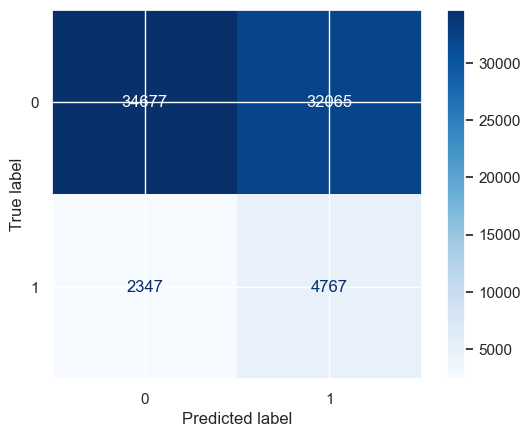

In [28]:
y_val_tensor_cpu_2 = y_val_tensor_2.cpu()
predictions_cpu_2 = predictions_2.cpu()
prob_cpu_2 = probabilities_2.cpu()

y_val_numpy_2 = y_val_tensor_cpu_2.numpy()
predictions_numpy_2 = predictions_cpu_2.numpy()

plot_cmap(y_val_numpy_2, predictions_numpy_2)

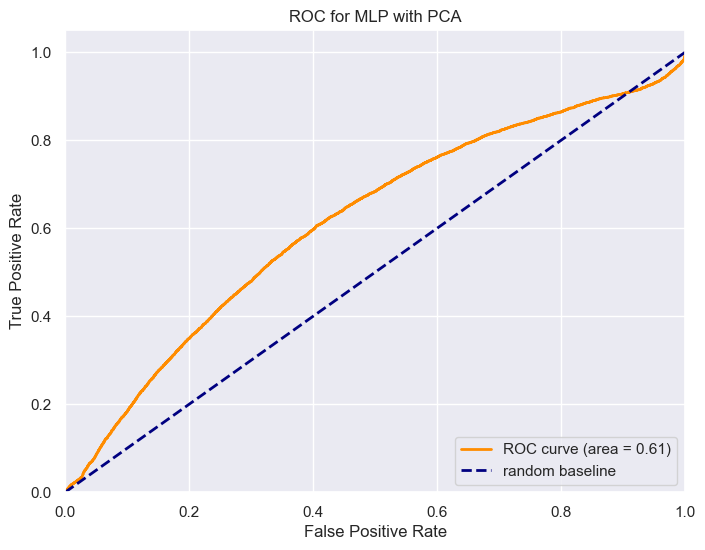

In [29]:
plot_roc_curve_mlp(prob_cpu_2, y_val_numpy_2, title = 'ROC for MLP with PCA')

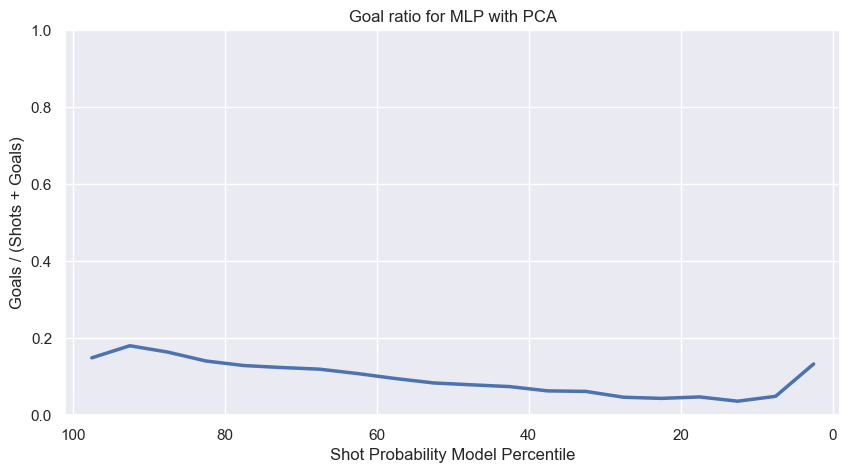

In [30]:
plot_goal_ratio_mlp(prob_cpu_2, y_val_numpy_2,predictions_cpu_2, title = 'Goal ratio for MLP with PCA')

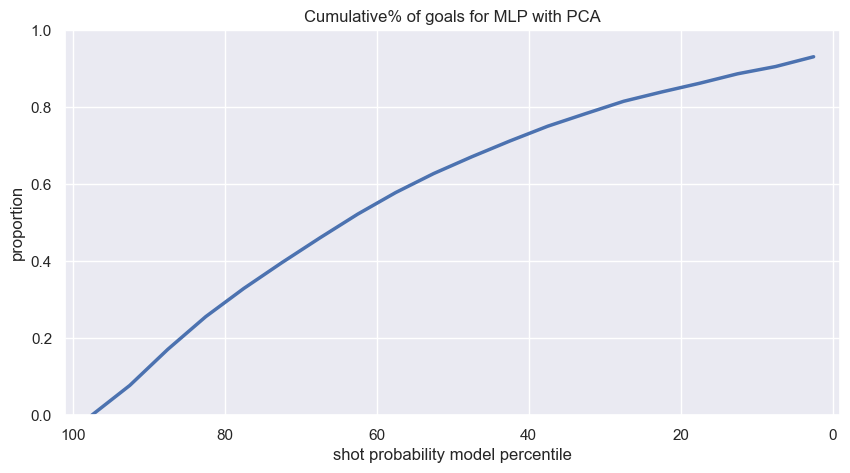

In [31]:
plot_cumu_goal_mlp(prob_cpu_2, y_val_numpy_2,predictions_cpu_2, title = 'Cumulative% of goals for MLP with PCA')

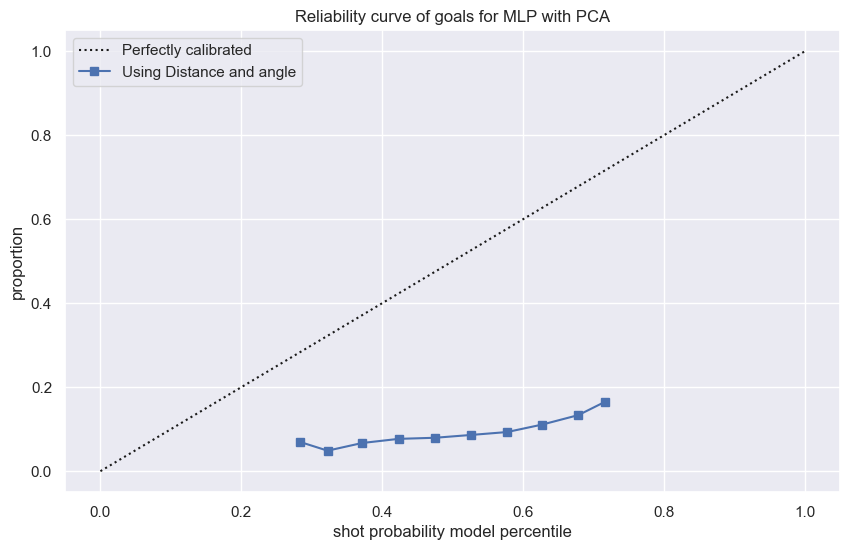

In [32]:
plot_calib_mlp(prob_cpu_2, y_val_numpy_2,predictions_cpu_2, title = 'Reliability curve of goals for MLP with PCA')

In [35]:
test_acc = metrics.accuracy_score(y_val_numpy_2,predictions_cpu_2)
print(f"Test accuracy :{test_acc}")
    
experiment.log_metric("Test accuracy", test_acc)
experiment.log_model("mlp_pca", os.path.join("./trained_models", file_name))
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/6e2463c7cb6443ebabe1c3a16b11007e
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.5340662911611785
COMET INFO:   Parameters:
COMET INFO:     copy      : True
COMET INFO:     with_mean : True
COMET INFO:     with_std  : True
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     figures                      : 4
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COME

Test accuracy :0.5340662911611785
